In [1]:
import numpy as np
import matplotlib.pyplot as plt 
# from PDF_Sq_silica import pdf_sq_silica
import my_common as mc
# import os
import scipy.constants as scc
import scipy.integrate 
from scipy import optimize
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter
from scipy.integrate import cumulative_trapezoid
import scienceplots
plt.style.use('science')

In [2]:
import scienceplots
plt.style.use(['science'])

In [3]:
delta_r = 0.02  # unit is A
#     r_max = box[0,0]/2*10
r_max = 10
#     r = np.linspace(delta_r, r_max, int(r_max / delta_r))
r = np.arange(delta_r, r_max, delta_r)
R = r[1:] - delta_r / 2

In [4]:
y_force = np.load('../data/force_matching.npz')['y_force'] # forces on Si atoms 
X = np.load('../data/force_matching.npz')['X']
y_force2 = np.load('../data/force_matching.npz')['y_force2'] # forces on O atoms
X2 = np.load('../data/force_matching.npz')['X2']

In [5]:
print(X.shape,X2.shape)

(180000, 798) (360000, 798)


In [19]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       Xtrain3:  3.9 GiB
                           tmp:  1.1 GiB
                        Xtest3: 986.3 MiB
                      y_force3:  4.1 MiB
                       ytrain3:  3.3 MiB
                      y_force2:  2.7 MiB
                       y_force:  1.4 MiB
                        ytest3: 843.9 KiB
                             r:  4.0 KiB
                             R:  4.0 KiB


In [5]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_force,random_state=1,test_size=0.2)
model_ridge = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,
                                   alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])) # alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge.fit(Xtrain,ytrain)
# model_lasso = linear_model.LassoCV(cv=10,fit_intercept=True,normalize=False)
print(model_ridge.score(Xtest,ytest))
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y_force2,random_state=1,test_size=0.2)
model_ridge2 = linear_model.RidgeCV(cv=10,fit_intercept=False,normalize=False,) # ,alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1])
model_ridge2.fit(Xtrain2,ytrain2)
print(model_ridge2.score(Xtrain2,ytrain2))

/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was depr

0.8866881146711914


/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/zheng/miniconda3/envs/r2/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was depr

0.9237493775528591


In [5]:
# training together all the pairs
y_force3 = np.concatenate((y_force,y_force2))

nrange = int(X.shape[1]/2)
# Si-Si,Si-O
tmp = np.zeros((X.shape[0],nrange))
XX1 = np.hstack((X,tmp))
# O-Si, O-O
tmp = np.zeros((X2.shape[0],nrange))
XX2 = np.hstack((tmp,X2))
X3 = np.vstack((XX1,XX2))

In [7]:
del XX1, XX2, X, X2 

In [9]:
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X3, y_force3,random_state=10,test_size=0.2)
model_ridge3 = linear_model.RidgeCV(cv=5,fit_intercept=False,
                                   alphas=np.array([1e-8,1e-6,1e-4,1e-3,1e-2,1e-1]))
model_ridge3.fit(Xtrain3,ytrain3)
print(np.mean((ytest3-model_ridge3.predict(Xtest3))**2)**0.5)

0.8985892918918589


In [11]:
kcalpermole2ev = 1000*scc.calorie/scc.Avogadro/scc.electron_volt

f_SiSi3 = model_ridge3.coef_[:nrange]/kcalpermole2ev
f_SiO3 = model_ridge3.coef_[nrange:2*nrange]/kcalpermole2ev
f_OO3 = model_ridge3.coef_[2*nrange:]/kcalpermole2ev

# fitting forces with different functional forms 

In [12]:
# Buckingham + Coulomb 
def BuckinghamCoulomb(r,qq,A,B,C):
    """
    force form, unit = kcal/mol/A
    This form is the same as the BKS potential, qq unit: e2, A unit: eV, B: 1/A, C: eV*A6
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + A*B*np.exp(-B*r) /kcalpermole2ev 
            - 6*C/r**7 /kcalpermole2ev) # + 4*D*((12)*E**12/r**12/kcalpermole2ev)

In [178]:
R = R[R<8]

q_Si_list = np.arange(0.4,1.4,0.01)
loss_list = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_Si**2,1388,3,175],bounds=([qf_Si**2-1e-8,0,0,0],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_O**2,1388,4,300],bounds=([qf_O**2-1e-8,0,0,0],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]

    # print(params_SiSi,params_SiO,params_OO)
    
    # considering the error at the large distances that are more risky (more interaction pairs at large distances)
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(BuckinghamCoulomb(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(BuckinghamCoulomb(R[(R>cut_test1)*(R<cut_test2)],*params_SiO)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(BuckinghamCoulomb(R[(R>cut_test1)*(R<cut_test2)],*params_OO)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list.append(loss)

In [46]:
# without the reweightting based on R, the optimal charge of Si goes from 0.83 to 0.85

In [76]:
def Morse_Coulomb_force(r,qq,De,a,re):
    """
    force form (Morse), unit = kcal/mol/A
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )

def Morse_Coulomb_energy(r,qq,De,a,re):
    """
    force form (Morse), unit = kcal/mol/A
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + De*(1-np.exp(-(a*(r-re))))**2)

In [179]:
R = R[R<8]

q_Si_list = np.arange(0.4,1.4,0.01)
loss_list_Morse = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_Si**2,-1,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,1e8,1e8,1e8]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,-1,1,1],bounds=([qf_O*qf_Si-1e-8,-1e8,-1e8,-1e8],[qf_O*qf_Si,1e8,1e8,1e8]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_O**2,-1,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8,-1e8],[qf_O**2,1e8,1e8,1e8]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]

    # print(params_SiSi,params_SiO,params_OO)
    
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi_Morse)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]***(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO_Morse)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**0*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO_Morse)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list_Morse.append(loss)

<ipython-input-76-d428addd4451>:6: RuntimeWarning: overflow encountered in exp
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )
<ipython-input-76-d428addd4451>:6: RuntimeWarning: overflow encountered in multiply
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )


In [106]:
def LJ_Coulomb_force(r,qq,epsilon,sigma):
    """
    force form (Morse), unit = kcal/mol/A
    """
    return (1e20*qq/r**2*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev 
            + 4*epsilon*(12*(sigma/r)**13-6*(sigma/r)**7)  )

In [180]:
R = R[R<8]

q_Si_list = np.arange(0.4,1.4,0.01)
loss_list_LJ = []

for i in range(len(q_Si_list)):
    qf_Si = q_Si_list[i]
    qf_O = -qf_Si/2
    
    cut_test1 = 2.8
    cut_test2 = 5.5
    cut_SiSi = 2.4
    
    xfit = R[(R>cut_SiSi)*(R<cut_test2)]
    yfit=f_SiSi3[(R>cut_SiSi)*(R<cut_test2)]
    params_SiSi_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_Si**2,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8],[qf_Si**2,1e8,1e8]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
    cut_SiO = 1.3
    xfit = R[(R>cut_SiO)*(R<cut_test2)]
    yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
    params_SiO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,1,1],bounds=([qf_O*qf_Si-1e-8,-1e8,-1e8],[qf_O*qf_Si,1e8,1e8]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]
    
    cut_OO = 2.2
    xfit = R[(R>cut_OO)*(R<cut_test2)]
    yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
    params_OO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O**2,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8],[qf_O**2,1e8,1e8]),maxfev=1000000)[0]
#     params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,0,0,0],maxfev=1000000)[0]
    
    # print(params_SiSi,params_SiO,params_OO)
    
    loss = np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi_LJ)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO_LJ)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
            np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(LJ_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO_LJ)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4
    
    loss_list_LJ.append(loss)

In [148]:
R[(R>cut_test1)*(R<cut_test2)].shape[0]*3

405

charge of Si with minimum loss = 0.83
charge of Si with minimum loss = 0.91
charge of Si with minimum loss = 0.91


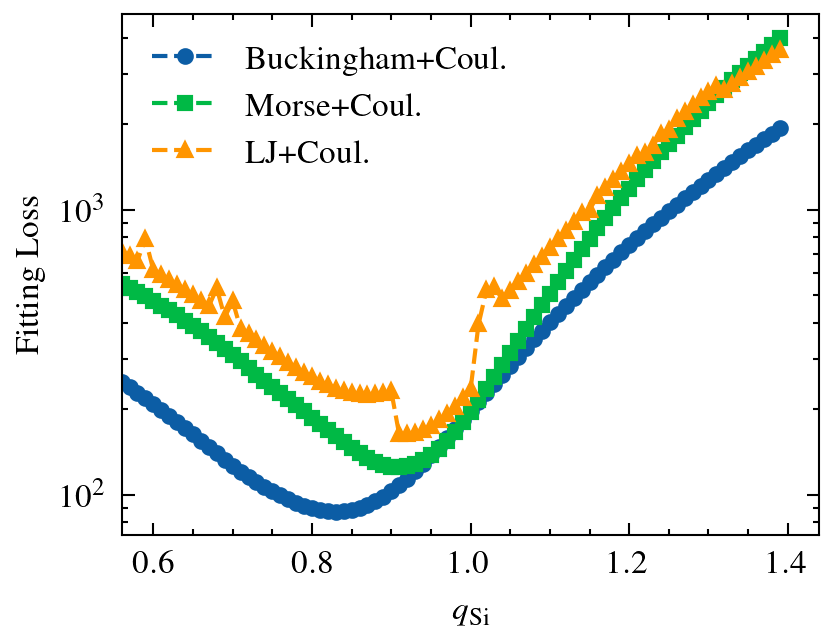

In [186]:
plt.figure(dpi=300,figsize=[3,2.3])
plt.semilogy(q_Si_list,np.array(loss_list)/405,'--o',ms=3,label='Buckingham+Coul.')
plt.plot(q_Si_list,np.array(loss_list_Morse)/405,'--s',ms=3,label='Morse+Coul.')
plt.plot(q_Si_list,np.array(loss_list_LJ)/405,'--^',ms=3,label='LJ+Coul.')

plt.ylabel('Fitting Loss') # r'$\sum_{r_{\alpha \beta,i}}||f_{fit}-f_{FM}||^2/\sum_{r_{\alpha \beta,i}} 1$'
plt.xlabel('$q_\mathrm{Si}$')
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list))]))
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list_Morse))]))
print('charge of Si with minimum loss = {:.2f}'.format(q_Si_list[np.argmin(np.array(loss_list_LJ))]))

plt.xlim(0.56)
plt.legend()

In [171]:
def F_wolf(r,q1,q2):
    return (1e20*q1*q2*(1/r**2-1/8**2)*scc.elementary_charge**2/4/np.pi/scc.epsilon_0/1e10/scc.electron_volt/kcalpermole2ev)
SR_cut = 5.5
gamma = 0.2

# Buckingham Coulomb

In [187]:
qf_Si = 0.82
qf_O = -qf_Si/2

xfit = R[(R>cut_SiSi)*(R<SR_cut)]
yfit=f_SiSi3[(R>cut_SiSi)*(R<SR_cut)]
params_SiSi_BKHC = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_Si**2,1388,3,175],bounds=([qf_Si**2-1e-8,0,0,0],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]

# cut_SiO1=1.5
cut_SiO2=1.3
xfit = R[(R>cut_SiO2)*(R<SR_cut)]
yfit=f_SiO3[(R>cut_SiO2)*(R<SR_cut)]
params_SiO_BKHC = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_O*qf_Si,18000,4.8,133],bounds=([qf_O*qf_Si-1e-8,0,0,0],[qf_O*qf_Si,100000,100000,10000]),maxfev=1000000)[0]

xfit = R[(R>cut_OO)*(R<SR_cut)]
yfit=f_OO3[(R>cut_OO)*(R<SR_cut)]
params_OO_BKHC = optimize.curve_fit(BuckinghamCoulomb, xfit, yfit, p0=[qf_O**2,1388,4,300],bounds=([qf_O**2-1e-8,0,0,0],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]
# params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,-100,1,3],bounds=([qf_O**2-1e-8,-100000,-100000,-100000],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]


In [222]:
# SiO, fitting buckingham+coulomb, + wolf
r=np.arange(0.001,8.001,0.001)
ffnew_SiO=np.zeros((len(r),3))
ffnew_SiO[:,0]=r
rcut = cut_SiO

ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_SiO_BKHC)
ffnew_SiO[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_Si)
# ffnew_SiO[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiO[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiO[r>SR_cut,2][0]
ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

xfit = ffnew_SiO[r>=rcut,0][:5]
yfit = ffnew_SiO[r>=rcut,2][:5]
p1 = np.polyfit(xfit,yfit,1) 
ffnew_SiO[r<rcut,2] = np.polyval(p1,ffnew_SiO[r<rcut,0])

ffnew_SiO[1:,1]=-cumulative_trapezoid(ffnew_SiO[:,2],x=r)
ffnew_SiO[:,1]=ffnew_SiO[:,1]-ffnew_SiO[-1,1]

# SiSi, fitting buckingham+coulomb, + wolf
ffnew_SiSi=np.zeros((len(r),3))
ffnew_SiSi[:,0]=r
rcut = 2.5

ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_SiSi_BKHC)
ffnew_SiSi[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_Si,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_Si,qf_Si)
# ffnew_SiSi[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiSi[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiSi[r>SR_cut,2][0]
ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -125
tmp = ffnew_SiSi[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_SiSi[r<rcut,2] = np.polyval(p1,ffnew_SiSi[r<rcut,0])

ffnew_SiSi[1:,1]=-cumulative_trapezoid(ffnew_SiSi[:,2],x=r)
ffnew_SiSi[:,1]=ffnew_SiSi[:,1]-ffnew_SiSi[-1,1]

# OO, fitting buckingham+coulomb, + wolf
ffnew_OO=np.zeros((len(r),3))
ffnew_OO[:,0]=r
rcut = cut_OO

ffnew_OO[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_OO_BKHC)
ffnew_OO[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_O)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_O)
# ffnew_OO[(r>=rcut)*(r<SR_cut),2]=(ffnew_OO[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_OO[r>SR_cut,2][0]
ffnew_OO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -200
tmp = ffnew_OO[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_OO[r<rcut,2] = np.polyval(p1,ffnew_OO[r<rcut,0])

ffnew_OO[1:,1]=-cumulative_trapezoid(ffnew_OO[:,2],x=r)
ffnew_OO[:,1]=ffnew_OO[:,1]-ffnew_OO[-1,1]

<ipython-input-222-9276bfa19861>:12: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-222-9276bfa19861>:32: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-222-9276bfa19861>:52: RuntimeWarning: divide by zero encountered in divide
  ffnew_OO[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp


# Morse 

In [211]:
qf_Si = 0.91
qf_O = -qf_Si/2

xfit = R[(R>cut_SiSi)*(R<SR_cut)]
yfit=f_SiSi3[(R>cut_SiSi)*(R<SR_cut)]
params_SiSi_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_Si**2,-1,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,1e8,1e8,1e8]),maxfev=1000000)[0]

# cut_SiO1=1.5
cut_SiO2=1.3
xfit = R[(R>cut_SiO2)*(R<SR_cut)]
yfit=f_SiO3[(R>cut_SiO2)*(R<SR_cut)]
params_SiO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_Si*qf_O,-1,1,1],bounds=([qf_Si*qf_O-1e-8,-1e8,-1e8,-1e8],[qf_Si*qf_O,1e8,1e8,1e8]),maxfev=1000000)[0]

xfit = R[(R>cut_OO)*(R<SR_cut)]
yfit=f_OO3[(R>cut_OO)*(R<SR_cut)]
params_OO_Morse = optimize.curve_fit(Morse_Coulomb_force, xfit, yfit, p0=[qf_O**2,-1,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8,-1e8],[qf_O**2,1e8,1e8,1e8]),maxfev=1000000)[0]
# params_OO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O**2,-100,1,3],bounds=([qf_O**2-1e-8,-100000,-100000,-100000],[qf_O**2,100000,10000,10000]),maxfev=1000000)[0]


<ipython-input-76-d428addd4451>:6: RuntimeWarning: overflow encountered in exp
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )
<ipython-input-76-d428addd4451>:6: RuntimeWarning: overflow encountered in multiply
  - 2*De*(1-np.exp(-(a*(r-re))))*a*np.exp(-(a*(r-re)))  )


In [215]:
(np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiSi_Morse)-f_SiSi3[(R>cut_test1)*(R<cut_test2)])**2) + \
        np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_SiO_Morse)-f_SiO3[(R>cut_test1)*(R<cut_test2)])**2)*2 + \
        np.sum(R[(R>cut_test1)*(R<cut_test2)]**2*(Morse_Coulomb_force(R[(R>cut_test1)*(R<cut_test2)],*params_OO_Morse)-f_OO3[(R>cut_test1)*(R<cut_test2)])**2)*4 )/405

124.75709075815782

In [224]:
# SiO, fitting buckingham+coulomb, + wolf
r=np.arange(0.001,8.001,0.001)
ffnew_SiO_morse=np.zeros((len(r),3))
ffnew_SiO_morse[:,0]=r
rcut = cut_SiO

ffnew_SiO_morse[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_SiO_Morse)
ffnew_SiO_morse[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_Si)
# ffnew_SiO_morse[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiO_morse[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiO_morse[r>SR_cut,2][0]
ffnew_SiO_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

xfit = ffnew_SiO_morse[r>=rcut,0][:5]
yfit = ffnew_SiO_morse[r>=rcut,2][:5]
p1 = np.polyfit(xfit,yfit,1) 
ffnew_SiO_morse[r<rcut,2] = np.polyval(p1,ffnew_SiO_morse[r<rcut,0])

ffnew_SiO_morse[1:,1]=-cumulative_trapezoid(ffnew_SiO_morse[:,2],x=r)
ffnew_SiO_morse[:,1]=ffnew_SiO_morse[:,1]-ffnew_SiO_morse[-1,1]

# SiSi, fitting buckingham+coulomb, + wolf
ffnew_SiSi_morse=np.zeros((len(r),3))
ffnew_SiSi_morse[:,0]=r
rcut = 2.5

ffnew_SiSi_morse[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_SiSi_Morse)
ffnew_SiSi_morse[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_Si,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_Si,qf_Si)
# ffnew_SiSi_morse[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiSi_morse[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiSi_morse[r>SR_cut,2][0]
ffnew_SiSi_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -50
tmp = ffnew_SiSi_morse[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_SiSi_morse[r<rcut,2] = np.polyval(p1,ffnew_SiSi_morse[r<rcut,0])

ffnew_SiSi_morse[1:,1]=-cumulative_trapezoid(ffnew_SiSi_morse[:,2],x=r)
ffnew_SiSi_morse[:,1]=ffnew_SiSi_morse[:,1]-ffnew_SiSi_morse[-1,1]

# OO, fitting buckingham+coulomb, + wolf
ffnew_OO_morse=np.zeros((len(r),3))
ffnew_OO_morse[:,0]=r
rcut = cut_OO

ffnew_OO_morse[(r>=rcut)*(r<=SR_cut),2]=BuckinghamCoulomb(r[(r>=rcut)*(r<=SR_cut)],*params_OO_Morse)
ffnew_OO_morse[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_O)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_O)
# ffnew_OO_morse[(r>=rcut)*(r<SR_cut),2]=(ffnew_OO_morse[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_OO_morse[r>SR_cut,2][0]
ffnew_OO_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -200
tmp = ffnew_OO_morse[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_OO_morse[r<rcut,2] = np.polyval(p1,ffnew_OO_morse[r<rcut,0])

ffnew_OO_morse[1:,1]=-cumulative_trapezoid(ffnew_OO_morse[:,2],x=r)
ffnew_OO_morse[:,1]=ffnew_OO_morse[:,1]-ffnew_OO_morse[-1,1]

<ipython-input-224-6694ac272dda>:12: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiO_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-224-6694ac272dda>:32: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiSi_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-224-6694ac272dda>:52: RuntimeWarning: divide by zero encountered in divide
  ffnew_OO_morse[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO_morse[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp


# LJ

In [226]:
qf_Si = 0.91
qf_O = -qf_Si/2

params_SiSi_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_Si**2,1,1],bounds=([qf_Si**2-1e-8,-1e8,-1e8],[qf_Si**2,1e8,1e8]),maxfev=1000000)[0]
#     params_SiSi = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_Si**2,0,0,0],bounds=([qf_Si**2-1e-8,-1e8,-1e8,-1e8],[qf_Si**2,100000,10000,10000]),maxfev=1000000)[0]
    
cut_SiO = 1.3
xfit = R[(R>cut_SiO)*(R<cut_test2)]
yfit=f_SiO3[(R>cut_SiO)*(R<cut_test2)]
params_SiO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O*qf_Si,1,1],bounds=([qf_O*qf_Si-1e-8,-1e8,-1e8],[qf_O*qf_Si,1e8,1e8]),maxfev=1000000)[0]
#     params_SiO = optimize.curve_fit(ff_form1, xfit, yfit, p0=[qf_O*qf_Si,0,0,0],maxfev=1000000)[0]

cut_OO = 2.2
xfit = R[(R>cut_OO)*(R<cut_test2)]
yfit=f_OO3[(R>cut_OO)*(R<cut_test2)]
params_OO_LJ = optimize.curve_fit(LJ_Coulomb_force, xfit, yfit, p0=[qf_O**2,1,1],bounds=([qf_O**2-1e-8,-1e8,-1e8],[qf_O**2,1e8,1e8]),maxfev=1000000)[0]

In [229]:
# SiO, fitting buckingham+coulomb, + wolf
r=np.arange(0.001,8.001,0.001)
ffnew_SiO_LJ=np.zeros((len(r),3))
ffnew_SiO_LJ[:,0]=r
rcut = cut_SiO

ffnew_SiO_LJ[(r>=rcut)*(r<=SR_cut),2]=LJ_Coulomb_force(r[(r>=rcut)*(r<=SR_cut)],*params_SiO_LJ)
ffnew_SiO_LJ[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_Si)
# ffnew_SiO_LJ[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiO_LJ[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiO_LJ[r>SR_cut,2][0]
ffnew_SiO_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

xfit = ffnew_SiO_LJ[r>=rcut,0][:5]
yfit = ffnew_SiO_LJ[r>=rcut,2][:5]
p1 = np.polyfit(xfit,yfit,1) 
ffnew_SiO_LJ[r<rcut,2] = np.polyval(p1,ffnew_SiO_LJ[r<rcut,0])

ffnew_SiO_LJ[1:,1]=-cumulative_trapezoid(ffnew_SiO_LJ[:,2],x=r)
ffnew_SiO_LJ[:,1]=ffnew_SiO_LJ[:,1]-ffnew_SiO_LJ[-1,1]

# SiSi, fitting buckingham+coulomb, + wolf
ffnew_SiSi_LJ=np.zeros((len(r),3))
ffnew_SiSi_LJ[:,0]=r
rcut = 2.5

ffnew_SiSi_LJ[(r>=rcut)*(r<=SR_cut),2]=LJ_Coulomb_force(r[(r>=rcut)*(r<=SR_cut)],*params_SiSi_LJ)
ffnew_SiSi_LJ[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_Si,qf_Si)
# cut_tmp = F_wolf(SR_cut,qf_Si,qf_Si)
# ffnew_SiSi_LJ[(r>=rcut)*(r<SR_cut),2]=(ffnew_SiSi_LJ[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_SiSi_LJ[r>SR_cut,2][0]
ffnew_SiSi_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -50
tmp = ffnew_SiSi_LJ[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_SiSi_LJ[r<rcut,2] = np.polyval(p1,ffnew_SiSi_LJ[r<rcut,0])

ffnew_SiSi_LJ[1:,1]=-cumulative_trapezoid(ffnew_SiSi_LJ[:,2],x=r)
ffnew_SiSi_LJ[:,1]=ffnew_SiSi_LJ[:,1]-ffnew_SiSi_LJ[-1,1]

# OO, fitting buckingham+coulomb, + wolf
ffnew_OO_LJ=np.zeros((len(r),3))
ffnew_OO_LJ[:,0]=r
rcut = cut_OO

ffnew_OO_LJ[(r>=rcut)*(r<=SR_cut),2]=LJ_Coulomb_force(r[(r>=rcut)*(r<=SR_cut)],*params_OO_LJ)
ffnew_OO_LJ[r>SR_cut,2]=F_wolf(r[r>SR_cut],qf_O,qf_O)
# cut_tmp = F_wolf(SR_cut,qf_O,qf_O)
# ffnew_OO_LJ[(r>=rcut)*(r<SR_cut),2]=(ffnew_OO_LJ[(r>=rcut)*(r<SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<SR_cut)]-SR_cut)**2)+cut_tmp
cut_tmp = ffnew_OO_LJ[r>SR_cut,2][0]
ffnew_OO_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp

slope_tmp = -200
tmp = ffnew_OO_LJ[r>=rcut,2][0] - slope_tmp*rcut
p1 = np.array([slope_tmp,tmp])
ffnew_OO_LJ[r<rcut,2] = np.polyval(p1,ffnew_OO_LJ[r<rcut,0])

ffnew_OO_LJ[1:,1]=-cumulative_trapezoid(ffnew_OO_LJ[:,2],x=r)
ffnew_OO_LJ[:,1]=ffnew_OO_morse[:,1]-ffnew_OO_LJ[-1,1]

<ipython-input-229-bb2360c42316>:12: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiO_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiO_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-229-bb2360c42316>:32: RuntimeWarning: divide by zero encountered in divide
  ffnew_SiSi_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_SiSi_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp
<ipython-input-229-bb2360c42316>:52: RuntimeWarning: divide by zero encountered in divide
  ffnew_OO_LJ[(r>=rcut)*(r<=SR_cut),2]=(ffnew_OO_LJ[(r>=rcut)*(r<=SR_cut),2]-cut_tmp)*np.exp(-gamma**2/(r[(r>=rcut)*(r<=SR_cut)]-SR_cut)**2)+cut_tmp


Text(0.5, 0, '$r$ ($\\mathrm{\\AA}$)')

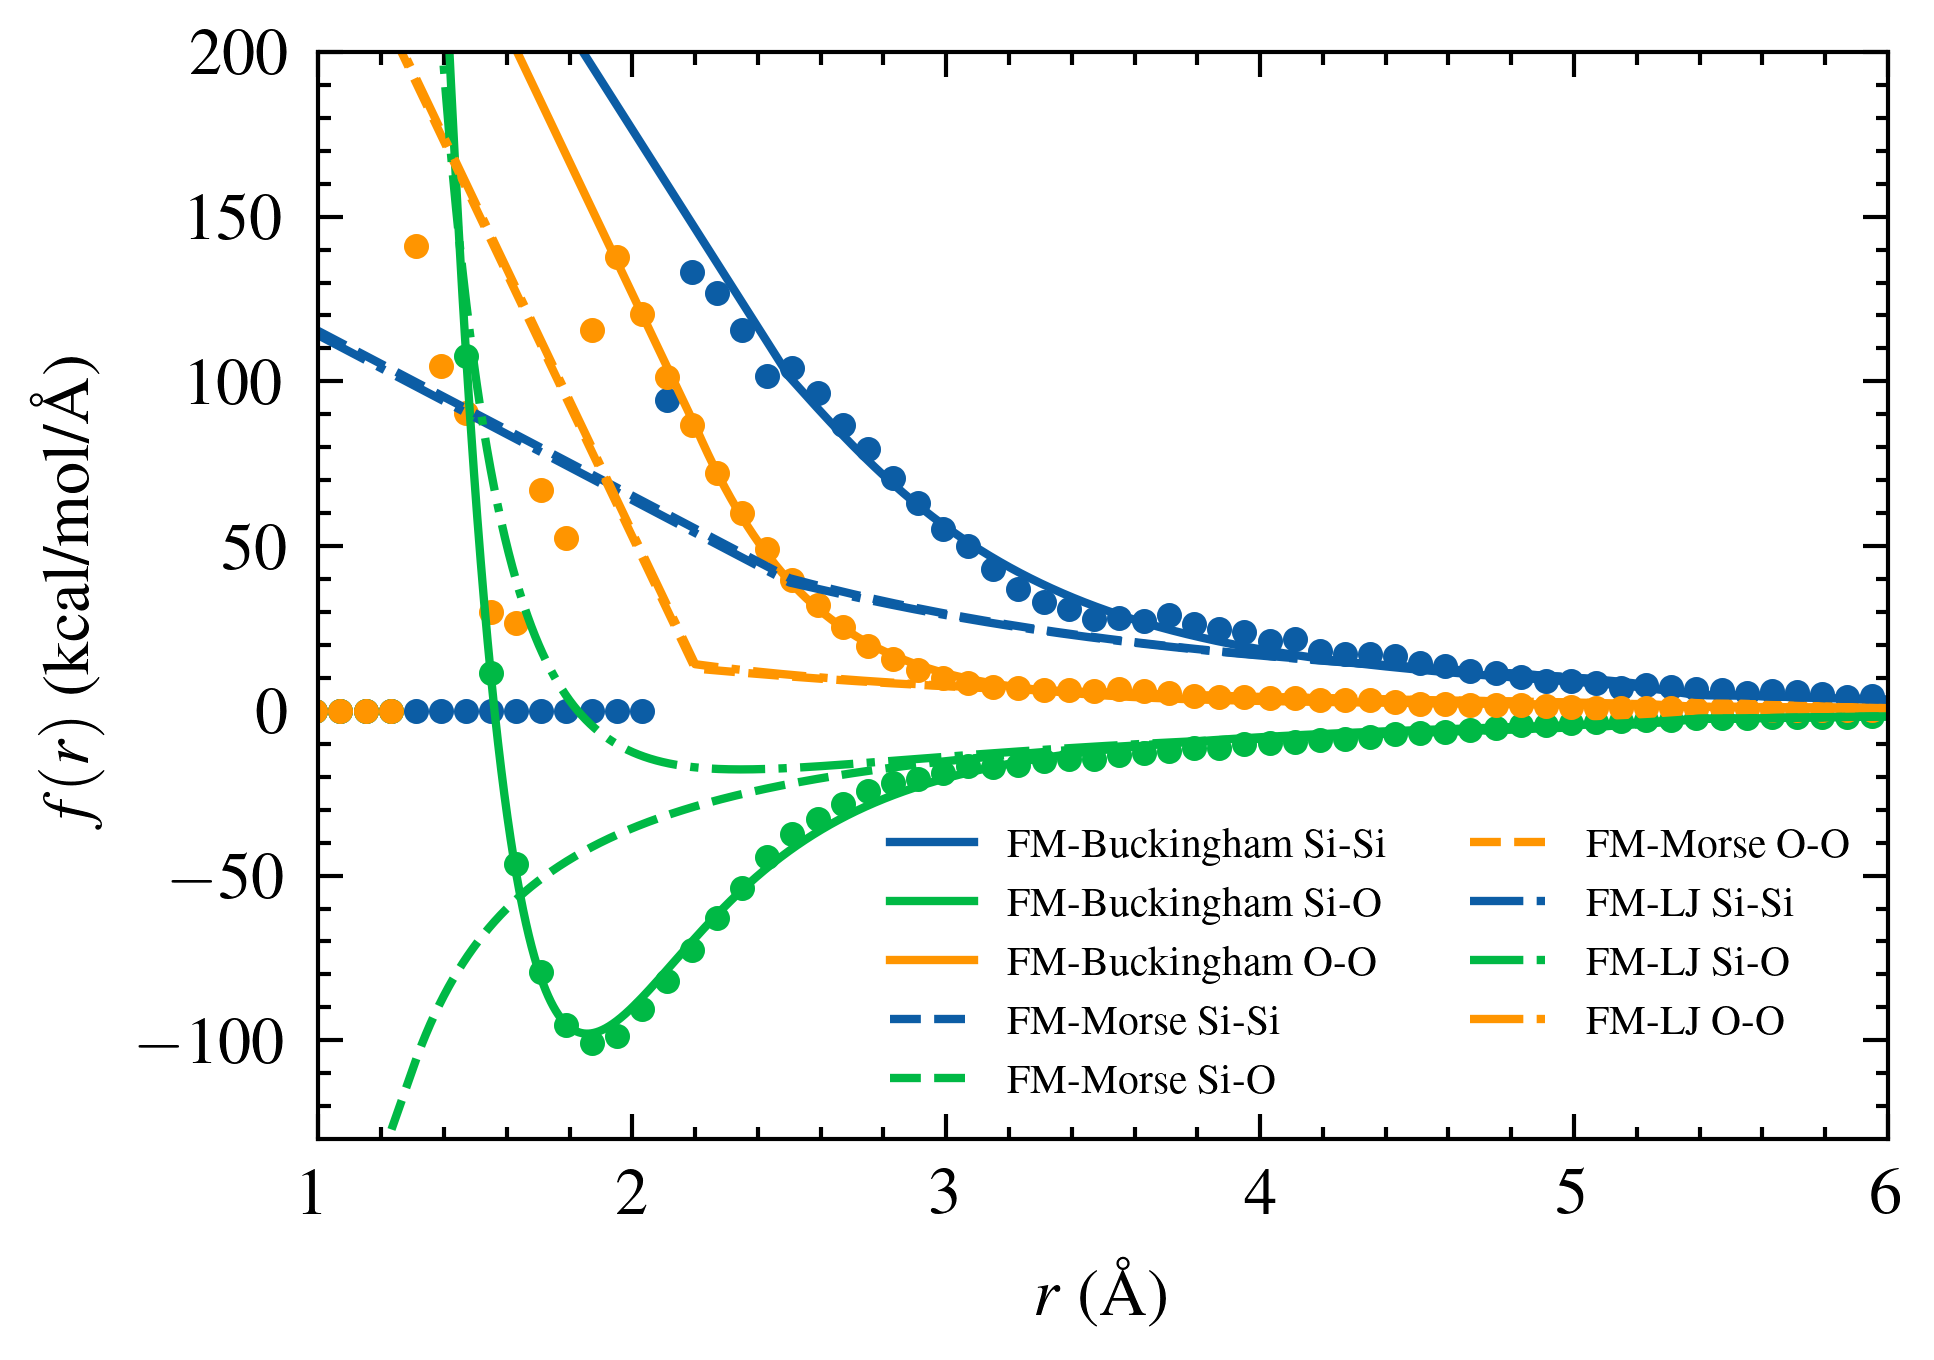

In [230]:
fig,ax=plt.subplots(1,1,dpi=600,figsize=[3+3/8,2.4])
plt.plot(R[::4],f_SiSi3[::4],'o',markersize=2)
plt.plot(R[::4],f_SiO3[::4],'o',markersize=2)
plt.plot(R[::4],f_OO3[::4],'o',markersize=2)

plt.plot(ffnew_SiSi[:,0],ffnew_SiSi[:,2],'C0-',label='FM-Buckingham Si-Si')
plt.plot(ffnew_SiO[:,0],ffnew_SiO[:,2],'C1-',label='FM-Buckingham Si-O')
plt.plot(ffnew_OO[:,0],ffnew_OO[:,2],'C2-',label='FM-Buckingham O-O')

plt.plot(ffnew_SiSi_morse[:,0],ffnew_SiSi_morse[:,2],'C0--',label='FM-Morse Si-Si')
plt.plot(ffnew_SiO_morse[:,0],ffnew_SiO_morse[:,2],'C1--',label='FM-Morse Si-O')
plt.plot(ffnew_OO_morse[:,0],ffnew_OO_morse[:,2],'C2--',label='FM-Morse O-O')

plt.plot(ffnew_SiSi_LJ[:,0],ffnew_SiSi_LJ[:,2],'C0-.',label='FM-LJ Si-Si')
plt.plot(ffnew_SiO_LJ[:,0],ffnew_SiO_LJ[:,2],'C1-.',label='FM-LJ Si-O')
plt.plot(ffnew_OO_LJ[:,0],ffnew_OO_LJ[:,2],'C2-.',label='FM-LJ O-O')

# plt.plot(ff_ss[:,1],ff_ss[:,3],'C3-',label='FM-fit Si-Si')
# plt.plot(ff_so[:,1],ff_so[:,3],'C4-',label='FM-fit Si-O')
# plt.plot(ff_oo[:,1],ff_oo[:,3],'C5-',label='FM-fit O-O')

plt.legend(fontsize=5,loc=4,ncol=2)

# axi= ax.inset_axes([0.55, 0.55, 0.45, 0.45])
# axi.tick_params(axis='both', which='major',labelsize=7)
# # axi.set_xlabel('$e_\mathrm{IS}$ (eV/atom)',fontsize=7)
# # axi.set_ylabel('$N_\mathrm{TLS}$',fontsize=7)

# axi.plot(R,f_SiSi3,'o',markersize=1,label='Si-Si')
# axi.plot(R,f_SiO3,'o',markersize=1,label='Si-O')
# axi.plot(R,f_OO3,'o',markersize=1,label='O-O')

# axi.plot(ffnew_SiSi[:,0],ffnew_SiSi[:,2],'C3--')
# axi.plot(ffnew_SiO[:,0],ffnew_SiO[:,2],'C4--')
# axi.plot(ffnew_OO[:,0],ffnew_OO[:,2],'C5--')

# axi.plot(ff_ss[:,1],ff_ss[:,3],'C3-',label='FM-fit Si-Si')
# axi.plot(ff_so[:,1],ff_so[:,3],'C4-',label='FM-fit Si-O')
# axi.plot(ff_oo[:,1],ff_oo[:,3],'C5',label='FM-fit O-O')

# axi.set_ylim(-20,29)
# axi.set_xlim(2.1,)

# plt.ylim(-20,30)
plt.ylim(-130,200)
plt.xlim(1,6)
plt.ylabel('$f(r)$ (kcal/mol/$\mathrm{\AA}$)')
plt.xlabel('$r$ ($\mathrm{\AA}$)')
# plt.savefig('/Volumes/GoogleDrive/My Drive/Research/silica_potential_AIMD/figures/ff_compare.pdf')

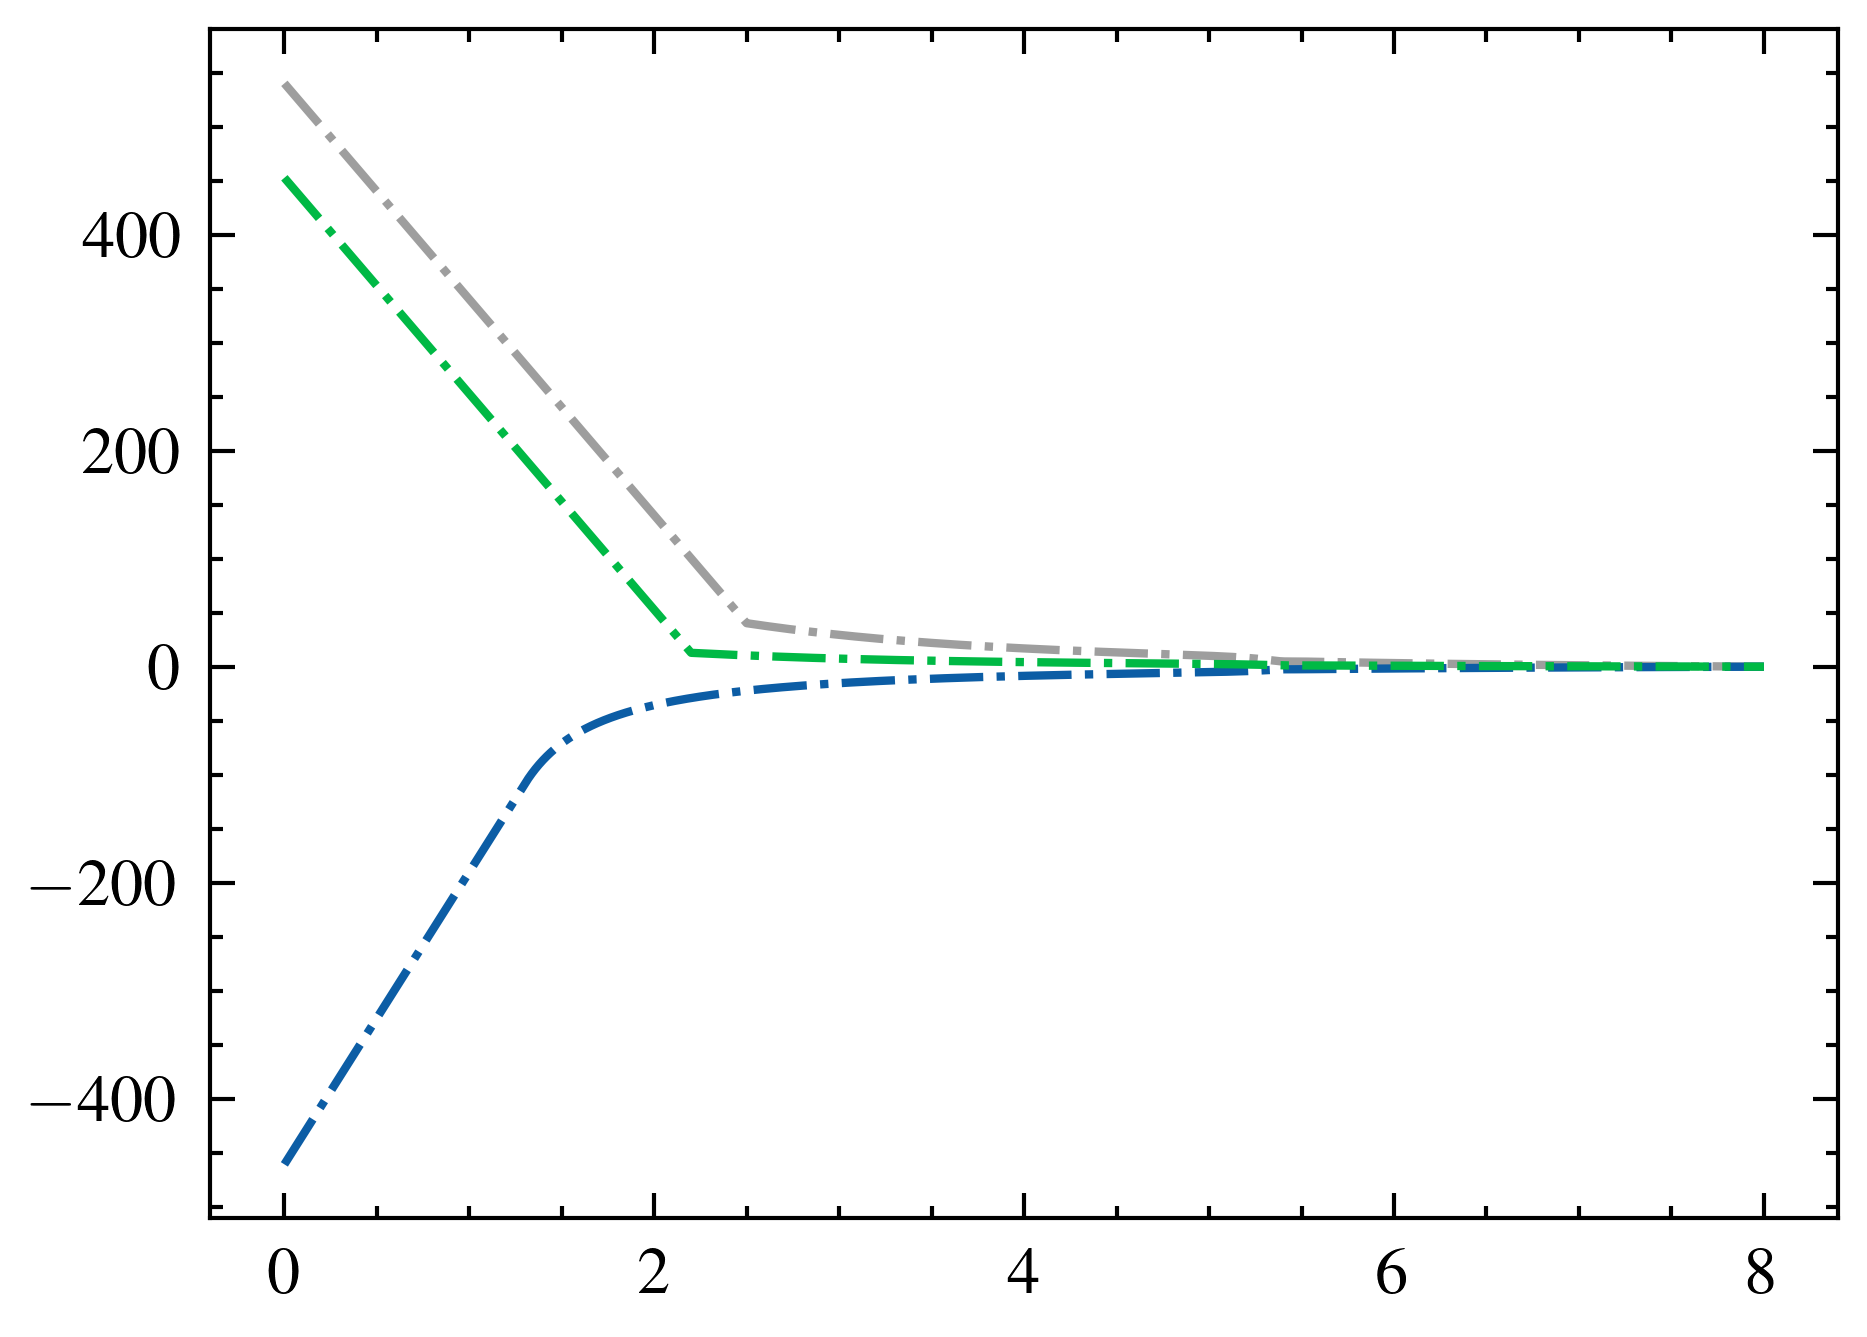

In [217]:
plt.plot(ffnew_SiSi_morse[:,0],ffnew_SiSi_morse[:,2],'C6-.',label='FM-Morse Si-Si')
plt.plot(ffnew_SiO_morse[:,0],ffnew_SiO_morse[:,2],'C7-.',label='FM-Morse Si-O')
plt.plot(ffnew_OO_morse[:,0],ffnew_OO_morse[:,2],'C8-.',label='FM-Morse O-O')